## Applied Question #8

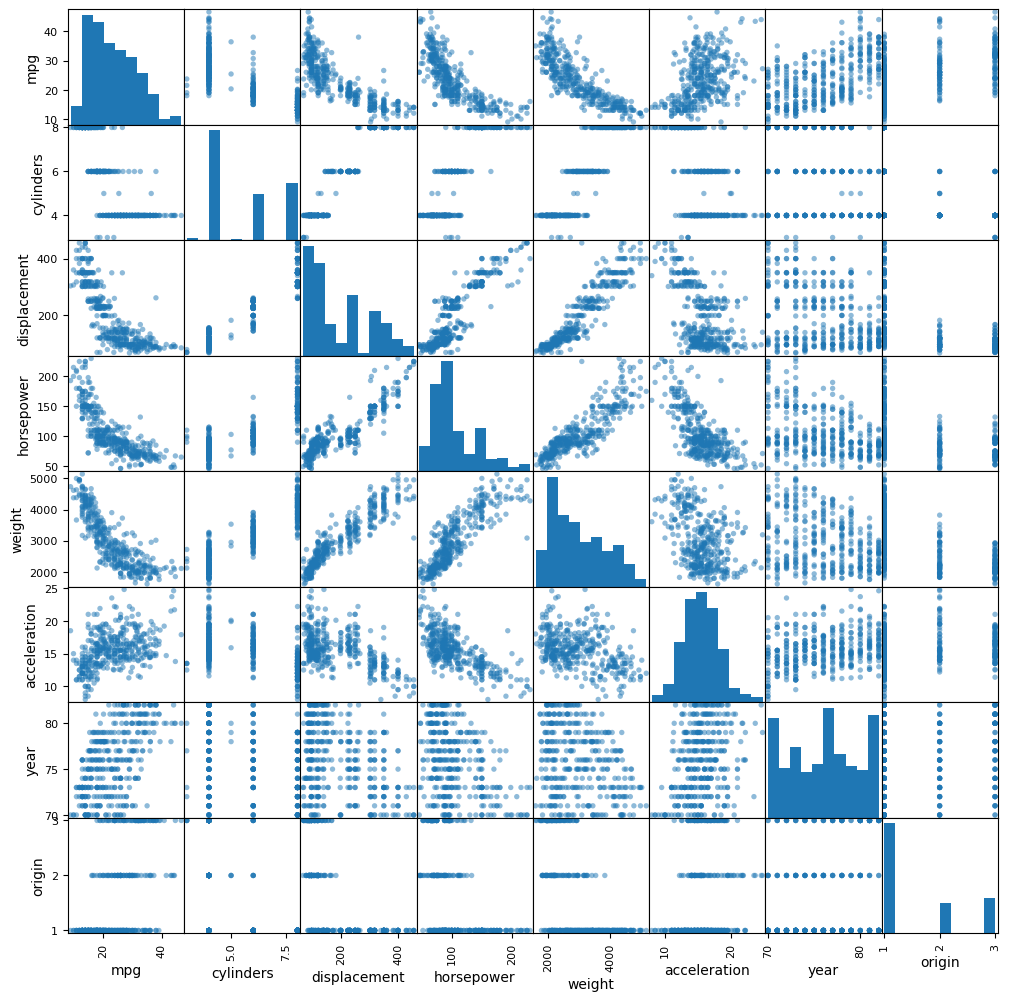

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from ISLP.models import sklearn_sm
from sklearn.model_selection import cross_validate, KFold
from pygam import (s as s_gam, LinearGAM)
from ISLP.models import ns

Auto = load_data('Auto')
horsepower = Auto['horsepower']
mpg = Auto['mpg']

smat=pd.plotting.scatter_matrix(Auto, figsize=(12, 12), marker='o', hist_kwds={'bins': 10}, s=15, alpha=0.5)

Plotting variables show several non-linear relationships. we are going to focus on mpg as target variable and plot it against displacement, horsepower, wight and acceleration.

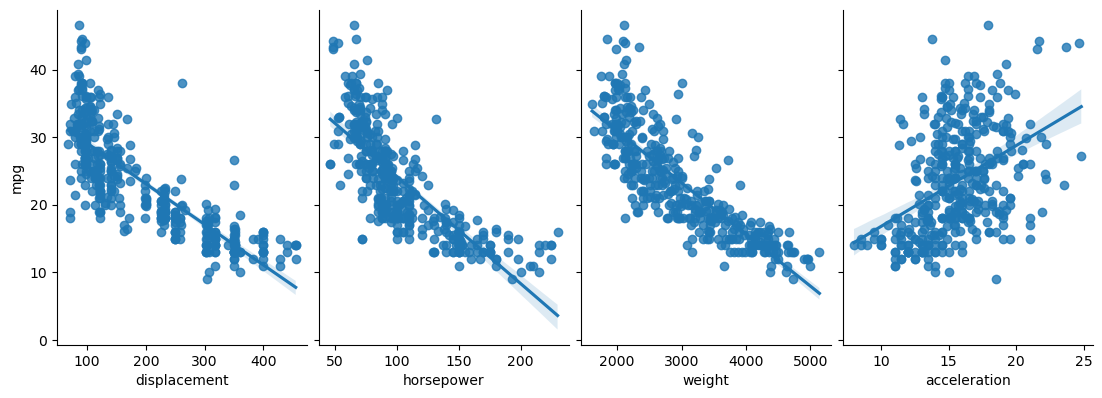

In [4]:
sns.pairplot(Auto, x_vars=['displacement', 'horsepower', 'weight', 'acceleration'], y_vars='mpg', height=4, aspect=0.7, kind='reg')
plt.show()

Plots show non-linear relationships between mpg and other variables. We select horsepower for further analysis.

In [6]:
cv_error = np.zeros(11)
H = np.array(horsepower)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=10, shuffle=True, random_state=55)
for i, d in enumerate(range(1, 12)):
    Xc = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M, Xc, mpg, cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
print(cv_error)

[24.18654596 19.29192012 19.39370451 19.55621741 19.20776775 19.17967328
 19.16413121 23.38543643 23.53857634 56.11761359 72.83419513]


cv_error stores the CV errors corresponding to the polynomial fits of degrees one to ten.  
We see a sharp drop in the estimated test MSE between the linear and quadratic fits, but then no clear improvement from using higher-degree polynomials.

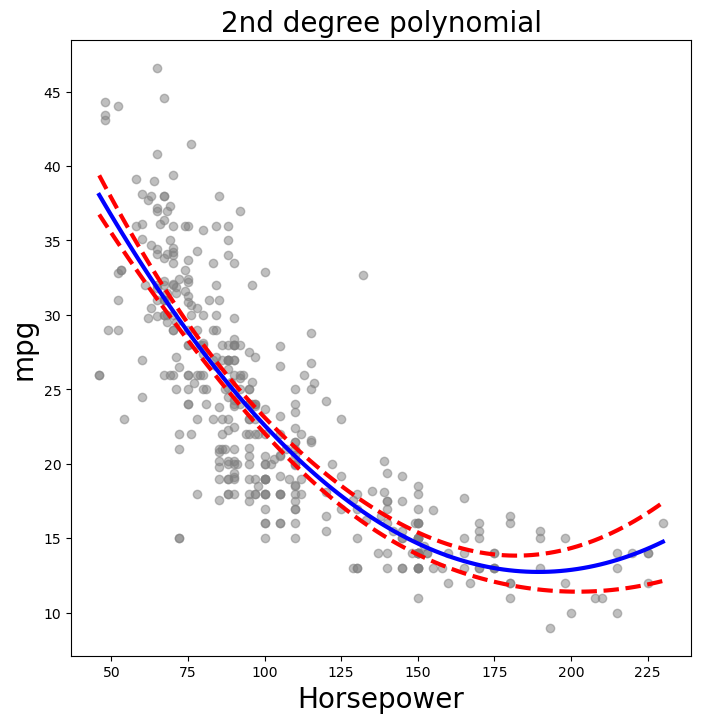

In [8]:
horsepower_grid = np.linspace(horsepower.min(), horsepower.max(), 100)
horsepower_df = pd.DataFrame({'horsepower': horsepower_grid})

def plot_mpg_fit(df, basis, title):
    X1 = basis.transform(Auto)
    Xnew1 = basis.transform(df)
    M = sm.OLS(mpg, X1).fit()
    preds = M.get_prediction(Xnew1)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(horsepower,mpg,facecolor='gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Horsepower', fontsize=20)
    ax.set_ylabel('mpg', fontsize=20);
    return ax

model2=MS([poly('horsepower', degree=2)]).fit(Auto)
plot_mpg_fit(horsepower_df, model2, '2nd degree polynomial');

In [14]:
X1 = model2.transform(Auto)
M = sm.OLS(mpg, X1).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,23.4459,0.221,106.130,0.0
"poly(horsepower, degree=2)[0]",-120.1377,4.374,-27.467,0.0
"poly(horsepower, degree=2)[1]",44.0895,4.374,10.080,0.0


p-values for all coeffiecients are significant

## Step Functions

In [19]:
cv_error_cuts = np.zeros(20)
for i, d in enumerate(range(1, 21)):
    Xcross = pd.qcut(horsepower, d+1)
    M_CV_cut = cross_validate(sklearn_sm(sm.OLS), pd.get_dummies(Xcross), mpg, cv=cv)
    cv_error_cuts[i] = np.mean(M_CV_cut['test_score'])
print(cv_error_cuts)

array([29.77306622, 23.57578423, 20.51566129, 21.48005148, 19.13732524,
       20.11790337, 19.31821982, 18.94757774, 19.76345291, 19.01721418,
       18.35924445, 19.65016486, 19.48110729, 19.07368509, 18.79900267,
       19.69108592, 18.96747279, 19.22762614, 19.27070674, 21.21785999])

We use cross-validation errors to find optimal number of cuts.

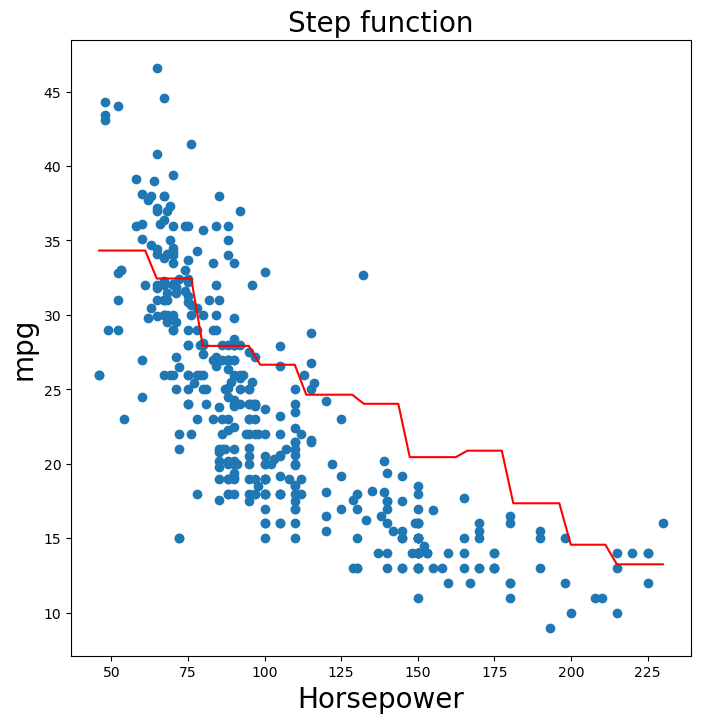

In [32]:
n_cuts = 10
cut_horse = pd.qcut(horsepower, n_cuts+1)
Xnewh = pd.get_dummies(cut_horse)
ynewh = mpg
rstep = sm.OLS(ynewh, Xnewh).fit()
Xh_grid=np.linspace(horsepower.min(),horsepower.max())
groupsh = pd.cut(Xh_grid, n_cuts+1)
yh_step = rstep.predict(pd.get_dummies(groupsh))
fig, ax = subplots(figsize=(8, 8))
plt.scatter(horsepower, mpg)
plt.plot(Xh_grid, yh_step, '-r')
ax.set_title('Step function', fontsize=20)
ax.set_xlabel('Horsepower', fontsize=20)
axylab = ax.set_ylabel('mpg', fontsize=20)

In [34]:
summarize(rstep)

,coef,std err,t,P>|t|
"(45.999, 65.0]",34.3243,0.701,48.982,0.0
"(65.0, 71.0]",32.4462,0.683,47.537,0.0
"(71.0, 78.0]",27.9235,0.731,38.198,0.0
"(78.0, 86.0]",26.6583,0.710,37.525,0.0
"(86.0, 90.0]",24.6452,0.658,37.471,0.0
"(90.0, 96.273]",24.0346,0.836,28.751,0.0
"(96.273, 105.0]",20.4524,0.658,31.096,0.0
"(105.0, 115.364]",20.8862,0.792,26.387,0.0
"(115.364, 145.0]",17.3553,0.691,25.099,0.0
"(145.0, 165.0]",14.5722,0.710,20.512,0.0


## Natual Spline

                            coef  std err       t  P>|t|
intercept                34.8412    1.442  24.165    0.0
ns(horsepower, df=5)[0] -10.7387    1.468  -7.314    0.0
ns(horsepower, df=5)[1] -14.3807    1.794  -8.015    0.0
ns(horsepower, df=5)[2] -21.6880    1.437 -15.094    0.0
ns(horsepower, df=5)[3] -23.0278    3.299  -6.979    0.0
ns(horsepower, df=5)[4] -21.3810    1.626 -13.149    0.0


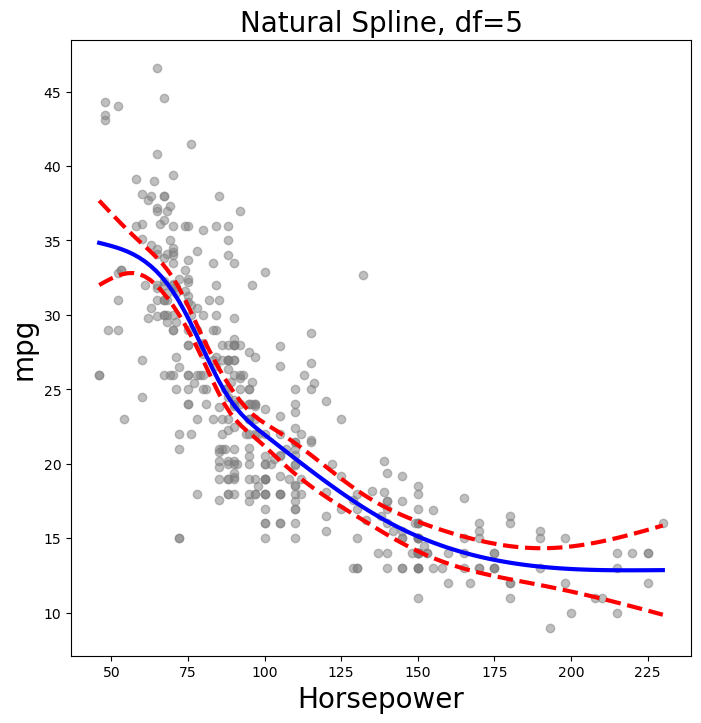

In [41]:
ns_horse = MS([ns('horsepower', df=5)]).fit(Auto)
M_nsh = sm.OLS(mpg, ns_horse.transform(Auto)).fit()
print(summarize(M_nsh))
axylab = plot_mpg_fit(horsepower_df, ns_horse, 'Natural Spline, df=5')

## Generalized Additive Models

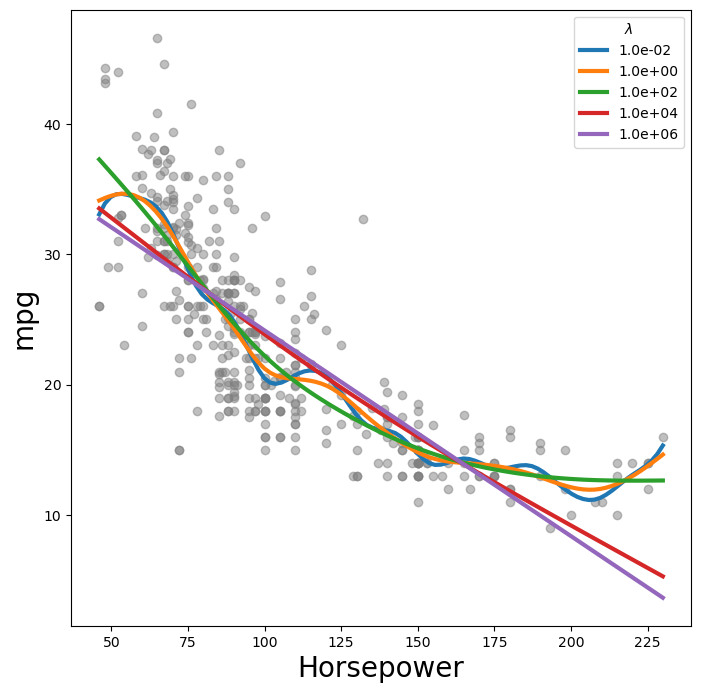

In [48]:
X_horsepower = np.asarray(horsepower).reshape((-1, 1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_horsepower, mpg)

fig, ax = subplots(figsize=(8, 8))
ax.scatter(horsepower, mpg, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_horsepower, mpg)
    ax.plot(horsepower_grid, gam.predict(horsepower_grid), label='{:.1e}'.format(lam), linewidth=3)
    ax.set_xlabel('Horsepower', fontsize=20)
    ax.set_ylabel('mpg', fontsize=20)
    ax.legend(title='$\\lambda$')

Optimum lambda

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


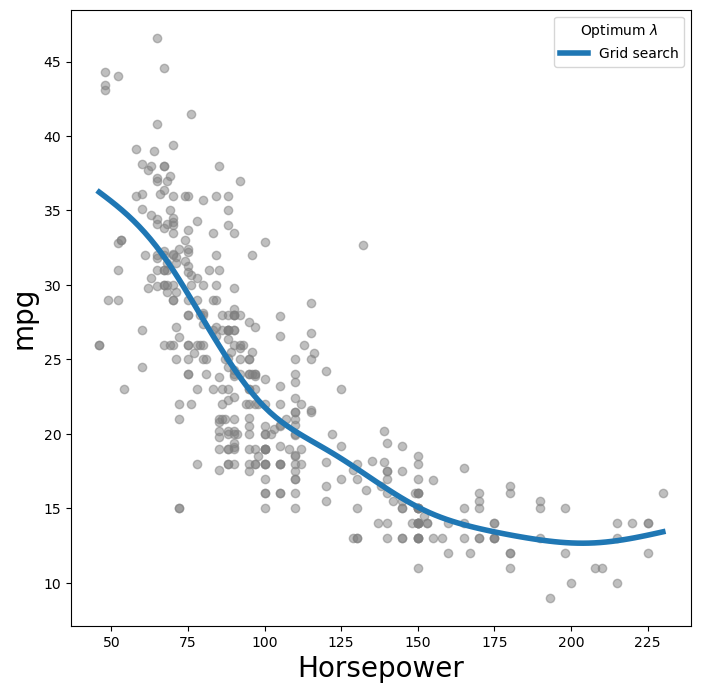

In [51]:
gam_opt = gam.gridsearch(X_horsepower, mpg)
fig, ax = subplots(figsize=(8, 8))
plt.scatter(horsepower, mpg, facecolor='gray', alpha=0.5)
plt.plot(horsepower_grid, gam_opt.predict(horsepower_grid), label='Grid search', linewidth=4)
ax.set_xlabel('Horsepower', fontsize=20)
ax.set_ylabel('mpg', fontsize=20)
axl = ax.legend(title='Optimum $\\lambda$')